# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [510]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import scipy.misc
%matplotlib inline



## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [511]:
import math



def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

def canny_param(img, low_threshold, high_threshold ):
    """Applies parameterized Canny edge detection"""
    return cv2.Canny(img, low_threshold, high_threshold)

# Kernel size should be greater than zero and odd
def gaussian_blur(img, kernel_size = 7):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)



def draw_lines(img, lines, thickness, color=[255, 0, 0]):
    """Draw a list of lines on a given image"""
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines_param(img, threshold, 
                      min_line_len, max_line_gap,rho = 1, theta = np.pi/180):
    """
    Returns hough lines computed
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α, β, λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [512]:
def compute_rectangle_param(img, left_b_x, right_b_x, left_u_x, right_u_x, upper_y, lower_y):
    """For given x coordinates of 4 points as well as bottom and top y coordinate of a polygon,
    it returns the polygon vertices"""
    row, col = image.shape[:2]
    left_b_v  = (col*left_b_x, row*lower_y)
    left_t_v  = (col*left_u_x, row*upper_y)
    right_b_v = (col*right_b_x, row*lower_y)
    right_t_v  = (col*right_u_x, row*upper_y) 
    return np.array([[left_b_v,right_b_v, right_t_v, left_t_v]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



def avg_slope_intercept(lines):
    
    """This is the function for smoothing detected hough lines into only two smoothed , continued lines
    We can do that by converting average slope and intercept for both lanes(right and left)
    and then convert it into pixel points.
    y- coordinate values are decreasing by going from the bottom to the top an image.
    x - coordinate values are increasing by going from the left to the right of an image.
    Given that the slope  s = (y2-y1)/(x2-x1) we can see that s is positive for the left lane
    and negative for the right lane"""
    
    left_lines = []
    right_lines = []
    avg_left = None
    avg_right = None
    if lines is not None:
        for line in lines:
            for x1,y1,x2,y2 in line:
                #Skip vertical lines and horizontal lines
                if x1 != x2 and y1 != y2:
                    slope = (y2 - y1)/(x2 - x1)
                    intercept = y1 - slope*x1
                    if slope > 0:
                        left_lines.append((slope, intercept))
                    else:
                        right_lines.append((slope, intercept))

        if(len(left_lines) > 0):
            avg_left = tuple((sum([left_line[0]for left_line in left_lines])/len(left_lines), 
                             sum([left_line[1]for left_line in left_lines])/len(left_lines)))
            
        if(len(right_lines) > 0):
            avg_right = tuple((sum([right_line[0]for right_line in right_lines])/len(right_lines), 
                             sum([right_line[1]for right_line in right_lines])/len(right_lines)))
    return avg_left, avg_right


def modified_avg_slope_intercept(lines):
    
    """This is similar to the previous function but computes "weighted" average for slope and intercept.
    The main idea here is to give more weight to longer lines , when computing intercept and slope.
    This idea stems from an assumption that noisy lines are shorter"""
    
    left_lines = []
    right_lines = []
    left_weights = []
    right_weights = []
    avg_left = None
    avg_right = None
    if lines is not None:
        for line in lines:
            if line is not None:
                for x1,y1,x2,y2 in line:
                    #Skip vertical lines and horizontal lines
                    if x1!=x2 and y1!=y2:
                        slope = (y2 - y1)/(x2 - x1)
                        intercept = y1 - slope*x1
                        weight = np.sqrt((y2-y1)**2+(x2-x1)**2)
                        if slope > 0:
                            left_lines.append((slope, intercept))
                            left_weights.append((weight))
                        else:
                            right_lines.append((slope, intercept))
                            right_weights.append((weight))
        #Compute weighted average

        if len(left_weights) > 0:
            avg_left = np.dot(left_weights, left_lines)/np.sum(left_weights) 

        if len(right_weights)>0:
            avg_right = np.dot(right_weights, right_lines)/np.sum(right_weights) 
    return avg_left, avg_right
    
    

def get_points_from_line(y1, y2, lane):
    """Get pixel points for given scope and intercept.
    Return integers because of cv2.line"""
    
    slope = lane[0]
    intercept = lane[1]
    x1 = (int)((y1 - intercept)/slope)
    x2 = (int)((y2 - intercept)/slope)
    return (x1, (int)(y1)), (x2, (int)(y2))


def compute_smooth_lanes_param(img, lines, mid_point, low_point):
    """This function computes 'smooth' lanes by creating smoothed lines from two points.
    y-coordinates are picked from near-bottom and near-mid area of an image (top and bottom of a masking polygon).
    Corresponding x-coordinates are computed using previously computed intercept and slope."""
    
    left_lane, right_lane = avg_slope_intercept(lines)
    
    y1 = img.shape[0]*low_point
    
    y2 = img.shape[0]*mid_point
    lane_lines = []
    
    if left_lane is not None:
        left_line  = get_points_from_line(y1, y2, left_lane)
        lane_lines.append(np.array([[left_line[0][0], left_line[0][1], left_line[1][0], left_line[1][1]]]))
    
    if right_lane is not None:
        right_line = get_points_from_line(y1, y2, right_lane)
        lane_lines.append(np.array([[right_line[0][0], right_line[0][1], right_line[1][0], right_line[1][1]]]))
    
        
    return lane_lines   

def compute_smooth_lanes_param_challenge(img, lines, mid_point, low_point):
    """Same as the previous but using "weighted" average for slope and 
    intercept, to give less weight to outliers"""
    
    left_lane, right_lane = modified_avg_slope_intercept(lines)
    
    y1 = img.shape[0]*low_point
    
    y2 = img.shape[0]*mid_point
    lane_lines = []
    
    if left_lane is not None:
        left_line  = get_points_from_line(y1, y2, left_lane)
        lane_lines.append(np.array([[left_line[0][0], left_line[0][1], left_line[1][0], left_line[1][1]]]))
    
    if right_lane is not None:
        right_line = get_points_from_line(y1, y2, right_lane)
        lane_lines.append(np.array([[right_line[0][0], right_line[0][1], right_line[1][0], right_line[1][1]]]))
    
        
    return lane_lines   
    


def draw_lanes(img, lines, thickness, color = [255,0,0]):
    """Draw lines on a blank image and merge it with original image."""
     
    line_img = np.zeros_like(img)
    draw_lines(line_img, lines, thickness)
    return weighted_img(img, line_img, 1.0, 0.95)


In [515]:
"""Pipeline that ties up everything together """

def FromImgToHoughLines(img, canny_lower , canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, up_y, low_y,
                       h_threshold, h_min_line_len, h_max_line_gap):
    
    """This function applies all steps up to computing hough lines"""
    gray = grayscale(img)
    blur_gray = gaussian_blur(gray)
    canny_edges = canny_param(blur_gray, canny_lower, canny_upper)
    masked_image = region_of_interest(canny_edges, compute_rectangle_param(img,left_low_x, right_low_x, 
                                                                           left_up_x, right_up_x, up_y, low_y))
    return hough_lines_param(masked_image, h_threshold, h_min_line_len, h_max_line_gap)



def line_detector_raw(img, canny_lower, canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, up_y, low_y,
                     h_threshold, h_min_line_len, h_max_line_gap):
    """This function ties up everything to detect and draw Hough lines on an original image."""
    lines = FromImgToHoughLines(img, canny_lower, canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, 
                                up_y, low_y, h_threshold, h_min_line_len, h_max_line_gap)
    return draw_lanes(img, lines, 5)



def line_detector(img, canny_lower, canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, up_y, low_y,
                     h_threshold, h_min_line_len, h_max_line_gap):
    """This function ties up everything to detect and draw smoothed Hough lines on an original image."""
    lines = FromImgToHoughLines(img, canny_lower, canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, up_y, 
                                low_y,h_threshold, h_min_line_len, h_max_line_gap)
    smoothed_lanes = compute_smooth_lanes_param(img, lines, up_y, low_y)
    return draw_lanes(img,smoothed_lanes,10)


 

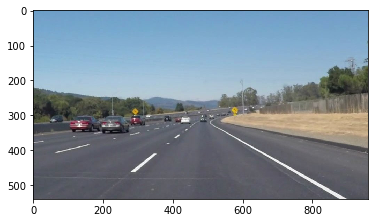

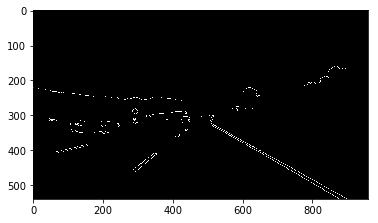

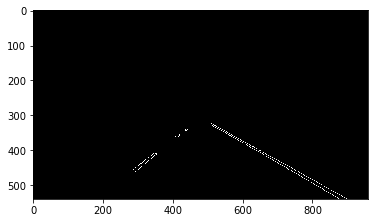

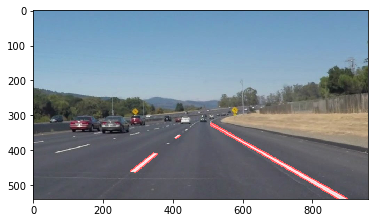

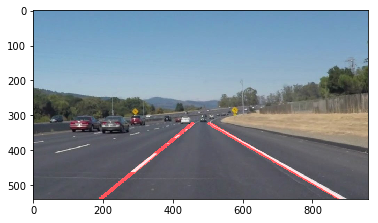

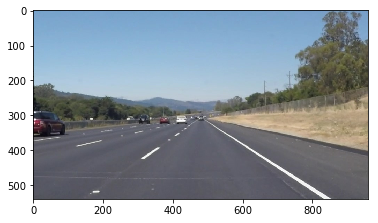

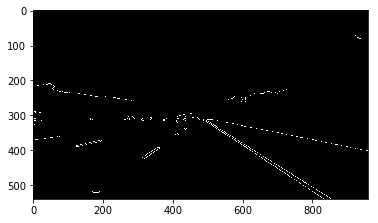

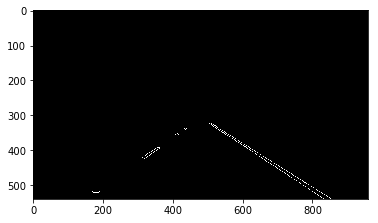

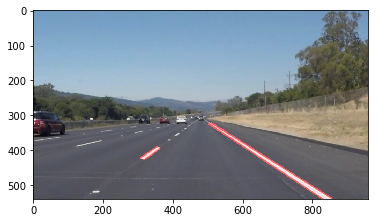

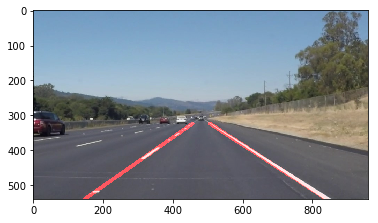

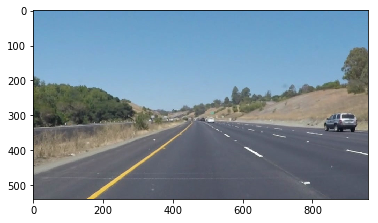

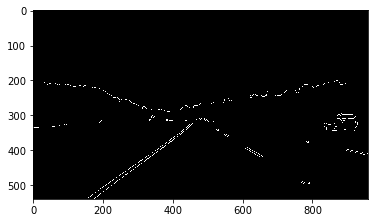

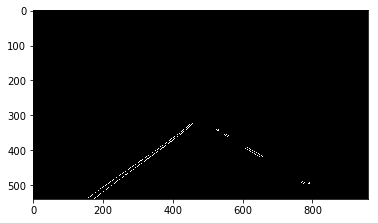

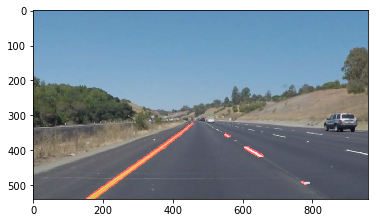

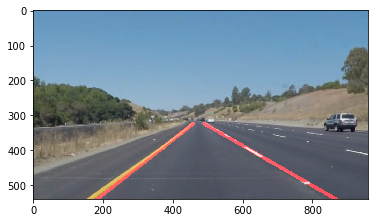

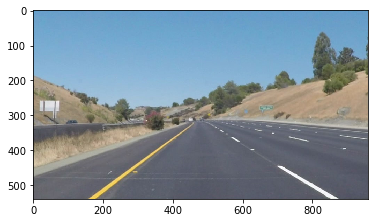

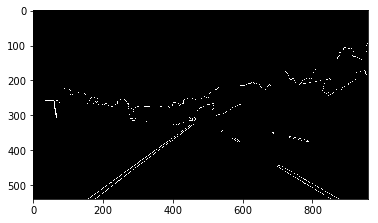

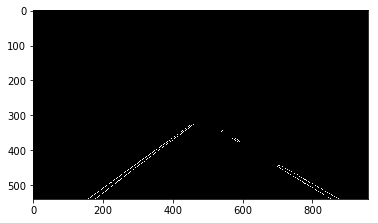

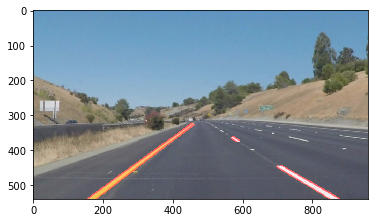

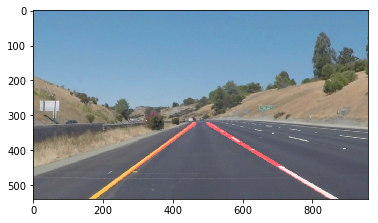

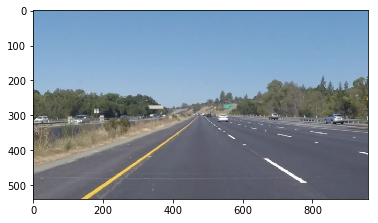

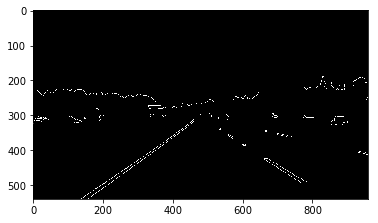

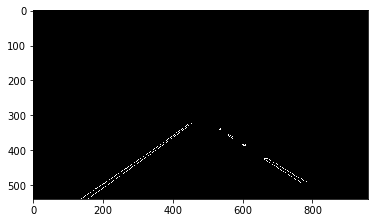

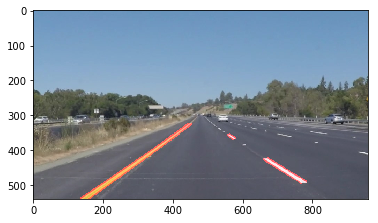

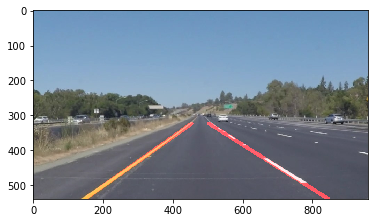

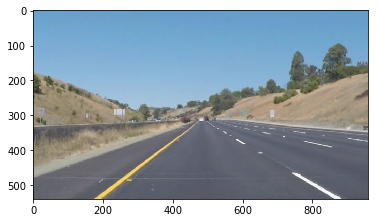

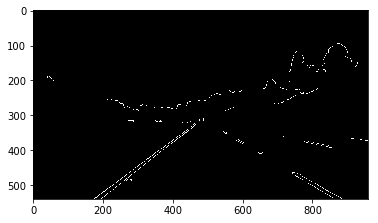

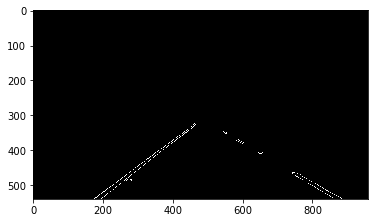

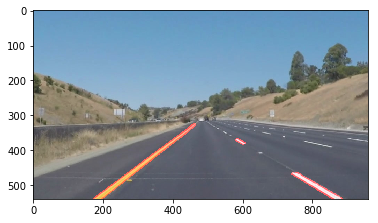

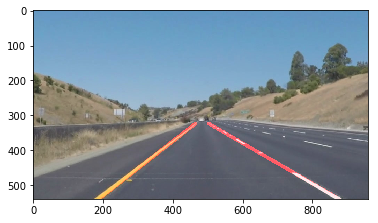

In [516]:
"""Demonstrate step by step on all test images."""
test_imgs =  os.listdir("test_images/")

for test_img in test_imgs:
    path = "test_images/" + test_img
    image = mpimg.imread(path,'jpg')
   
    blured_img = gaussian_blur(image, 7)
   
    canny_edges = canny_param(blured_img, 100, 220)
    
    masked_image = region_of_interest(canny_edges, 
                                      compute_rectangle_param(canny_img,0.09, 0.95, 0.45, 0.55, 0.6, 1.0 ))
    
    hough_lines_d = hough_lines_param(masked_image,20,10,10)
    
    image_with_hough = draw_lanes(image, hough_lines_d, 5)
    smoothed_lanes = compute_smooth_lanes_param(image, hough_lines_d, 0.6, 1.0)
    image_with_smoothed = draw_lanes(image, smoothed_lanes, 10)
    plt.figure()
    plt.imshow(image)
    plt.figure()
    plt.imshow(canny_edges, cmap = 'gray')
    plt.figure()
    plt.imshow(masked_image, cmap = 'gray')
    plt.figure()
    plt.imshow(image_with_hough)
    plt.figure()
    plt.imshow(image_with_smoothed)
    

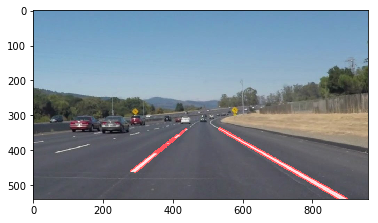

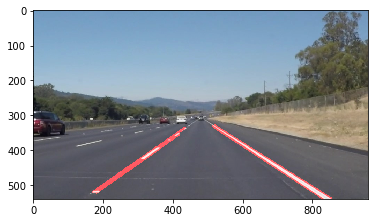

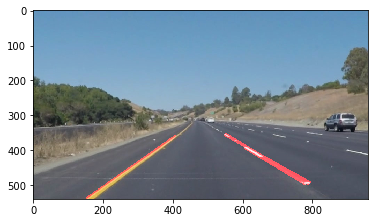

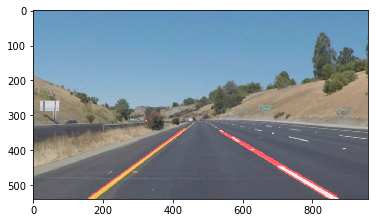

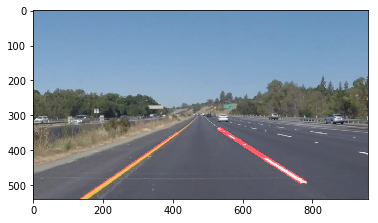

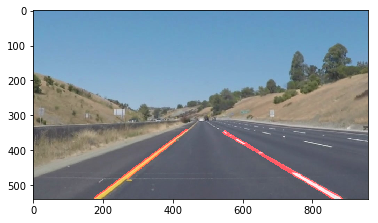

In [517]:
"""Run pipeline function on test images"""
for test_img in test_imgs:
    path = "test_images/" + test_img
    image = mpimg.imread(path,'jpg')
    plt.figure()
    out_array = line_detector_raw(image, 200, 250, 0.09, 0.95, 0.45, 0.55, 0.6, 1.0, 20,20,200)
    plt.imshow(out_array)
    scipy.misc.imsave("test_images_output/" + test_img, out_array)


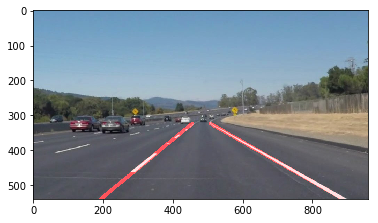

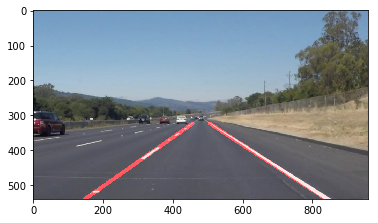

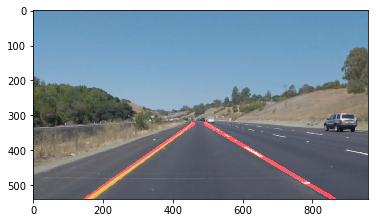

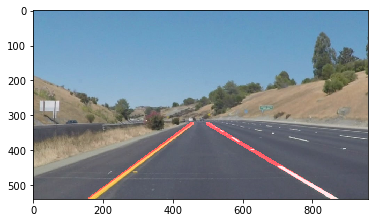

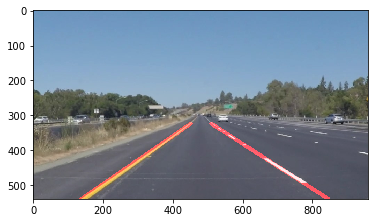

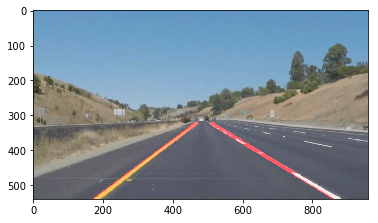

In [518]:
"""Run improved lane detection pipeline on test images"""
for test_img in test_imgs:
    path = "test_images/" + test_img
    image = mpimg.imread(path,'jpg')
    plt.figure()
    out_array = line_detector(image, 200, 250, 0.09, 0.95, 0.45, 0.55, 0.6, 1.0, 20,20,200)
    plt.imshow(out_array)
    scipy.misc.imsave("test_images_output/" + "improved_" + test_img, out_array)

# Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [519]:
"""Import everything needed to edit/save/watch video clips"""
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [520]:
"""This function detects smoothed continued left and right lane by using average intercept and slope"""
def process_image(image):
    return line_detector(image,200, 255, 0.09, 0.95, 0.45, 0.55, 0.60, 1.0, 20,10,10)

"""This function detects Hough lines - they can be discontiuned and consist of many smaller lines""" 
def process_image_raw(image):
    return line_detector_raw(image,200, 255, 0.09, 0.95, 0.45, 0.55, 0.60, 1.0, 20,10,10)
    

Let's try the one with the solid white lane on the right first ...

In [521]:
"""First trying lane detection pipeline without smoothing"""
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image_raw) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 94.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 1.71 s, sys: 352 ms, total: 2.06 s
Wall time: 2.73 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [522]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [523]:
"""Now trying lanes detection pipeline with lanes smoothing via average slope and intercept."""
yellow_output_improved = 'test_videos_output/solidYellowLeftImproved.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output_improved, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeftImproved.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeftImproved.mp4


100%|█████████▉| 681/682 [00:07<00:00, 87.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeftImproved.mp4 

CPU times: user 5.44 s, sys: 970 ms, total: 6.41 s
Wall time: 8.26 s


In [524]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output_improved))

In [525]:
white_output_improved = 'test_videos_output/solidWhiteRightImproved.mp4'
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
white_clip = clip2.fl_image(process_image)
%time white_clip.write_videofile(white_output_improved, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRightImproved.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRightImproved.mp4


100%|█████████▉| 221/222 [00:02<00:00, 95.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRightImproved.mp4 

CPU times: user 1.74 s, sys: 363 ms, total: 2.11 s
Wall time: 2.72 s


In [526]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output_improved))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

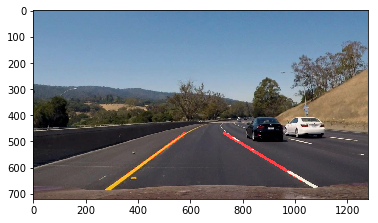

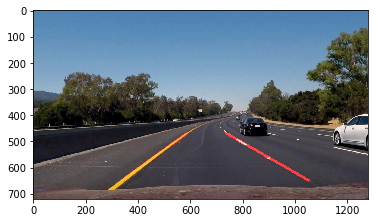

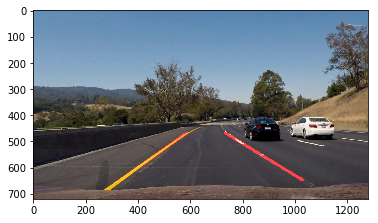

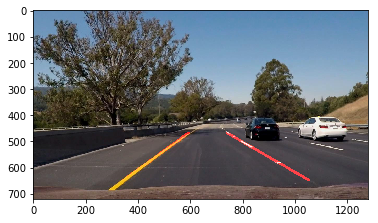

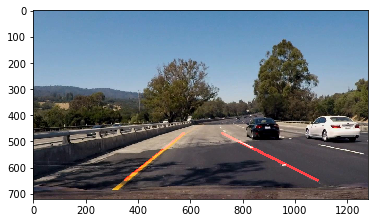

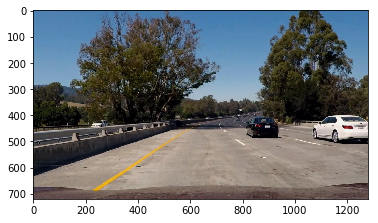

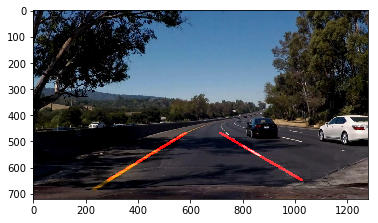

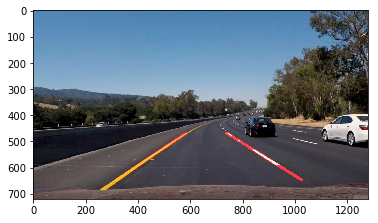

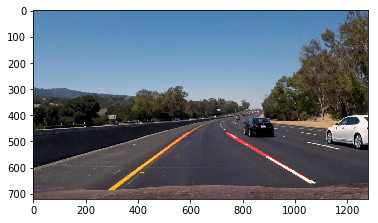

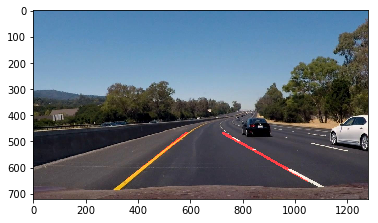

In [527]:
"""Get a couple of video frames to be able to do computations and see how accurate they are"""
from moviepy.editor import *

def extract_frames(movie, times, imgdir):
    clip = VideoFileClip(movie)
    for t in times:
        imgpath = os.path.join(imgdir, '{}.jpg'.format(t))
        clip.save_frame(imgpath, t)

movie = 'test_videos/challenge.mp4'
imgdir = 'frames'
times = 1.0,2.0, 3.0,4.0,5.0, 6.0, 7.0,8.0, 9.0, 10.0

extract_frames(movie, times, imgdir)

"""Images from the challenge video are full of noise. The left lower corner of the highway wall is as light as lane.
The car in the neigboring lane has light parts. Lanes are curved.
Possible solutions : Since lanes are curvy, they can't be approximated correctly with linear function.
Another approach I tried is to look at the lanes like they are straigh, and the curving part is like noise.
So instead of computing average slope and interception for smoothed lanes, I computed weighted average slope
and intercept.
The weight is a length of each Hough line, so shorter lanes , that are most likely a noise, will be included with a much 
smaller weight."""
    
def line_detector_challenge(img,canny_lower, canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, up_y, low_y,
                     h_threshold, h_min_line_len, h_max_line_gap ):
    lines = FromImgToHoughLines(img, canny_lower, canny_upper, left_low_x, right_low_x, left_up_x, right_up_x, up_y, low_y,
                     h_threshold, h_min_line_len, h_max_line_gap)
    smoothed_lanes = compute_smooth_lanes_param_challenge(img, lines, up_y, low_y)
    return draw_lanes(img,smoothed_lanes,10)

def process_image_challenge(img):
    return line_detector_challenge(img, 242, 250, 0.2, 0.85, 0.4, 0.6, 0.65, 0.90, 20,10,10)

"""Run the challenge pipeline on some video frames."""
frame_imgs =  os.listdir("frames/")
for frame_img in frame_imgs:
    path = "frames/" + frame_img
    image = mpimg.imread(path,'jpg')
    image_with_lanes = process_image_challenge(image)
    plt.figure()
    plt.imshow(image_with_lanes)


    







In [528]:
#Challenge lane detection with weighted average smoothing function
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:05<00:00, 44.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 3.4 s, sys: 764 ms, total: 4.17 s
Wall time: 6.52 s


In [529]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))